In [1]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize
import datetime

%matplotlib inline

In [2]:
# assumes periodic BCs
def metropolis_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the Metropolis algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # randomly choose new state
    new_state = random.randint(1,q)
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # randomly choose new state excluding current one
    states = [i for i in range(1, q+1)]
    states = np.delete(states, grid[y,x]-1)
    new_state = np.random.choice(states)
    
    # checking the energy cost
    energy_i = potts_energy_spin(grid, [y,x])
    energy_f = potts_energy_spin(grid, [y,x], new_state)
    
    d_energy = int(energy_f - energy_i)
    
    # applying the metropolis algorithm
    if d_energy <= 0:
        grid[y,x] = new_state
        
    elif random.uniform(0,1) < boltz[str(d_energy)]:
        grid[y,x] = new_state
        
    else:
        d_energy = 0
        

    return [grid, d_energy]

In [3]:
def met_sweep(init, q, boltz):
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            # select random spin from the input spin grid
            x = random.choice(range(X))
            y = random.choice(range(Y))
            
            # randomly choose new state excluding current one
            states = [i for i in range(1, q+1)]
            states = np.delete(states, grid[y,x]-1)
            new_state = np.random.choice(states)

            # checking the energy cost
            energy_i = potts_energy_spin(grid, [y,x])
            energy_f = potts_energy_spin(grid, [y,x], new_state)

            d_energy = int(energy_f - energy_i)

            # applying the metropolis algorithm
            if d_energy <= 0:
                grid[y,x] = new_state

            elif random.uniform(0,1) < boltz[str(d_energy)]:
                grid[y,x] = new_state


    return grid

In [4]:
# assumes periodic boundary condition
def heatbath_potts(init, q, boltz):
    """Returns a grid evolved one step in the q-state Potts model using the heat-bath algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    # select random spin from the input spin grid
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    
    # compute the relevant energies for the heat-bath algorithm (only nearest neighbor interactions)
    # we only want to compute the energies that are non-zero
    check = []
    check.append(grid[(y+1) % Y, x])
    check.append(grid[(y-1) % Y, x])
    check.append(grid[y % Y, (x+1) % X])
    check.append(grid[y % Y, (x-1) % X])
    check = list(set(check))
    
    
    
    # initialize the probabilities to 1 because the zero energies have boltzmann factor equal to 1
    probs = np.ones(q)
    
    # replace the appropriate elements with the boltzman factors; note that order in probs is important!
    for c in check:
        e = potts_energy_spin(grid, [y,x], c)
        probs[c-1] = boltz[str(e)]
        
    probs = np.array(probs)/np.sum(probs)   
    
    new_state = np.random.choice(range(1, q+1), p = probs)
    
    grid[y,x] = new_state
    
    return grid

    

In [5]:
# assumes periodic boundary condition
def heatbath_sweep(init, q, boltz):
    """Returns a grid evolved one sweep in the q-state Potts model using the heat-bath algorithm"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(Y):
        for i in range(X):
            # select random spin from the input spin grid
            x = random.choice(range(X))
            y = random.choice(range(Y))


            # compute the relevant energies for the heat-bath algorithm (only nearest neighbor interactions)
            # we only want to compute the energies that are non-zero
            check = []
            check.append(grid[(y+1) % Y, x])
            check.append(grid[(y-1) % Y, x])
            check.append(grid[y % Y, (x+1) % X])
            check.append(grid[y % Y, (x-1) % X])
            check = list(set(check))

            # initialize the probabilities to 1 because the zero energies have boltzmann factor equal to 1
            probs = np.ones(q)

            # replace the appropriate elements with the boltzman factors; note that order in probs is important!
            for c in check:
                e = potts_energy_spin(grid, [y,x], c)
                probs[c-1] = boltz[str(e)]

            probs = np.array(probs)/np.sum(probs)   

            new_state = np.random.choice(range(1, q+1), p = probs)

            grid[y,x] = new_state
    
    return grid

    

In [6]:
def potts_energy_spin(init, spin, q = None):
    """Compute the energy of a spin on a Potts lattice"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    x = spin[1]
    y = spin[0]
    
    # allows you to change the value of the spin in question
    if q is not None:
        grid[y,x] = q
    
    energy = 0
    
    if grid[y, (x + 1) % X] == grid[y,x]:
        energy += -1

    if grid[y, (x - 1) % X] == grid[y,x]:
        energy += -1

    if grid[(y + 1) % Y, x] == grid[y,x]:
        energy += -1

    if grid[(y - 1) % Y, x] == grid[y,x]:
        energy += -1
    
    return energy
    
    
    

In [7]:
def potts_energy(init):
    """Computes the energy of a Potts grid"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            spin_energy = potts_energy_spin(init, [i,j])
            energy += spin_energy
            
    return energy/2
    
    

In [8]:
def potts_mag(init, roots):
    """Computes the magnetization of a Potts grid using a list of roots of unity"""
    
    grid = copy.copy(init)
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    mag = 0
    
    for i in range(Y):
        for j in range(X):
            d_mag = roots[grid[i,j]-1]
            mag += d_mag
            
    mag = abs(mag)
            
    return mag

In [9]:
def plot_potts(grid, title = '', cmap = plt.cm.coolwarm):
    """Plot a Potts grid using a color map"""
    
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(grid, cmap=cmap)
    plt.colorbar()
    
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

In [2]:
x_values = np.arange(0, 900*1000, 100)/900

In [103]:
ones = np.random.randint(1, 11, (30, 30))
grid1 = copy.copy(ones)
grid2 = copy.copy(ones)

T = 0.4
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}
met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}

In [83]:
energy_list = []
energy_list_met = []

start = time.time()
for i in range(900*1000):
    output1 = heatbath_potts(grid1, 10, boltz)
    output2 = metropolis_potts(grid2, 10, met_boltz)[0]
    
    if ((i + 1) % 100) == 0:
        energy_list.append(potts_energy(output1))
        energy_list_met.append(potts_energy(output2))

    grid1 = output1
    grid2 = output2
    
    if ((i+1) % 90000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/900}; {tick-start} seconds')
    
energy_list = np.array(energy_list)/900
energy_list_met = np.array(energy_list_met)/900



Sweep 100.0; 11.122299671173096 seconds
Sweep 200.0; 22.294695615768433 seconds
Sweep 300.0; 33.106995582580566 seconds
Sweep 400.0; 43.85283160209656 seconds
Sweep 500.0; 54.723660469055176 seconds
Sweep 600.0; 65.83107948303223 seconds
Sweep 700.0; 76.74704337120056 seconds
Sweep 800.0; 87.67094349861145 seconds
Sweep 900.0; 98.35825157165527 seconds
Sweep 1000.0; 109.07085585594177 seconds


In [85]:
np.save('potts30_t05_heatbath10.npy', energy_list)
np.save('potts30_t05_met10.npy', energy_list_met)

In [113]:
ones = np.random.randint(1, 3, (30, 30))
grid1 = copy.copy(ones)
grid2 = copy.copy(ones)

T = 0.4
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}
met_boltz = {'1' : np.exp(-1/T), '2' : np.exp(-2/T), '3' : np.exp(-3/T), '4' : np.exp(-4/T)}

In [114]:
energy_listq3 = []
energy_list_metq3 = []

start = time.time()
for i in range(900*1000):
    output1 = heatbath_potts(grid1, 2, boltz)
    output2 = metropolis_potts(grid2, 2, met_boltz)[0]
    
    if ((i + 1) % 100) == 0:
        energy_listq3.append(potts_energy(output1))
        energy_list_metq3.append(potts_energy(output2))

    grid1 = output1
    grid2 = output2
    
    if ((i+1) % 90000) == 0: 
        tick = time.time()
        print(f'Sweep {(i+1)/900}; {tick-start} seconds')
    
energy_listq3 = np.array(energy_listq3)/900
energy_list_metq3 = np.array(energy_list_metq3)/900


Sweep 100.0; 11.096011877059937 seconds
Sweep 200.0; 21.803655862808228 seconds
Sweep 300.0; 32.45574760437012 seconds
Sweep 400.0; 43.03492784500122 seconds
Sweep 500.0; 53.67858815193176 seconds
Sweep 600.0; 64.38176846504211 seconds
Sweep 700.0; 75.44405245780945 seconds
Sweep 800.0; 86.32132840156555 seconds
Sweep 900.0; 97.03938794136047 seconds
Sweep 1000.0; 107.7460401058197 seconds


In [118]:
np.save('potts30_t05_heatbath2.npy', energy_listq3)
np.save('potts30_t05_met2.npy', energy_list_metq3)

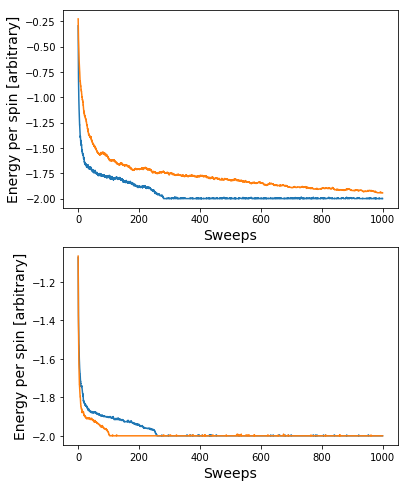

In [5]:
fig = plt.figure(figsize = (6,8))


fig.add_subplot(2, 1, 1)
plt.plot(x_values, energy_list)
plt.plot(x_values, energy_list_met)
plt.tick_params(axis='both', which='major', labelsize = 10)
plt.xlabel("Sweeps", fontsize=14)
plt.ylabel("Energy per spin [arbitrary]", fontsize=14)

fig.add_subplot(2, 1, 2)
plt.plot(x_values, energy_listq3)
plt.plot(x_values, energy_list_metq3)
plt.tick_params(axis='both', which='major', labelsize = 10)
plt.xlabel("Sweeps", fontsize=14)
plt.ylabel("Energy per spin [arbitrary]", fontsize=14)

plt.savefig('potts_equil.pdf', bbox_inches = 'tight')

In [11]:
init = np.random.randint(1, 6, (30, 30))
grid = copy.copy(init)

T = 0.2
boltz = {'-1' : np.exp(1/T), '-2' : np.exp(2/T), '-3' : np.exp(3/T), '-4' : np.exp(4/T)}

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

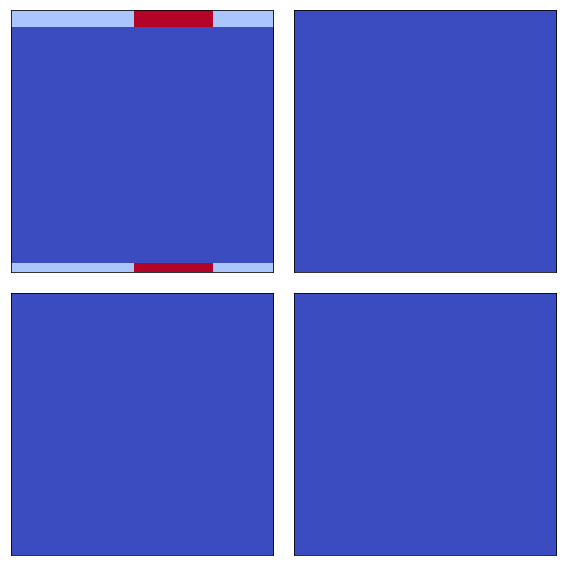

In [14]:
f, axes = plt.subplots(2,2)
f.set_size_inches(8,8)
plt.tight_layout(pad=0, w_pad=-1, h_pad=-1)

axarr = np.ndarray.flatten(axes)

for ax, num in zip(axarr, range(4)):
    for i in range(500):
        grid = heatbath_sweep(grid, 5, boltz)
    ax.imshow(grid, cmap = plt.cm.coolwarm)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
plt.colorbar()
    
#plt.savefig('4 Temps.pdf', bbox_inches='tight')